<a href="https://colab.research.google.com/github/bhar-gav/Intent-detection-models---banking-domain/blob/main/Enhanced_roberta_base_intent_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [9]:
from google.colab import drive
drive.mount("/content/drive")

import os
print(os.getcwd())
datasets="/content/drive/My Drive/Colab Notebooks/final-year/Nlp/"
os.chdir(datasets)
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/final-year/Nlp
/content/drive/My Drive/Colab Notebooks/final-year/Nlp


In [10]:
import os
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import re
import joblib
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Data Collection:

In [11]:
train_data = pd.read_csv(os.path.join("dataset/banking_data/train.csv"))
test_data = pd.read_csv(os.path.join("dataset/banking_data/test.csv"))

In [15]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10003 entries, 0 to 10002
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      10003 non-null  object
 1   category  10003 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


In [16]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3080 entries, 0 to 3079
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      3080 non-null   object
 1   category  3080 non-null   object
dtypes: object(2)
memory usage: 48.2+ KB


Data Cleaning:

In [12]:
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^\w\s]', '', text)  # punctuation
    text = re.sub(r'\d+', '', text)  # numbers
    return text

Data Preprocessing:

In [17]:
train_data['text'] = train_data['text'].apply(preprocess_text)
test_data['text'] = test_data['text'].apply(preprocess_text)

In [18]:

print("Sample Input:", train_data[:3])
print('Length of text_input:',len(train_data))

print("Sample Input:", test_data[:3])
print('Length of text_input:',len(test_data))

Sample Input:                                                 text      category
0                      i am still waiting on my card  card_arrival
1  what can i do if my card still hasnt arrived a...  card_arrival
2  i have been waiting over a week is the card st...  card_arrival
Length of text_input: 10003
Sample Input:                                                 text      category
0                            how do i locate my card  card_arrival
1  i still have not received my new card i ordere...  card_arrival
2  i ordered a card but it has not arrived help p...  card_arrival
Length of text_input: 3080


Lable encoder / intent encoding

In [19]:
label_encoder = LabelEncoder()
train_data['label'] = label_encoder.fit_transform(train_data['category'])
test_data['label'] = label_encoder.transform(test_data['category'])

Tokenization

In [20]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

train_encodings = tokenizer(train_data['text'].tolist(), truncation=True, padding=True, return_tensors='pt')
test_encodings = tokenizer(test_data['text'].tolist(), truncation=True, padding=True, return_tensors='pt')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [21]:
print(tokenizer)

RobertaTokenizer(name_or_path='roberta-base', vocab_size=50265, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}


In [24]:
print(train_encodings[:3])

{'input_ids': tensor([[    0,   118,   524,   202,  2445,    15,   127,  1886,     2,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1],
        [    0, 12196,    64,   939,   109,   114,   127,  1886,   202,    34,
          3999,  2035,    71,  1437,   688,     2,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1



---
Dataloaders


In [26]:
class IntentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [27]:
train_dataset = IntentDataset(train_encodings, train_data['label'].tolist())
test_dataset = IntentDataset(test_encodings, test_data['label'].tolist())

In [29]:
print(train_dataset[:2])

{'input_ids': tensor([[    0,   118,   524,   202,  2445,    15,   127,  1886,     2,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1],
        [    0, 12196,    64,   939,   109,   114,   127,  1886,   202,    34,
          3999,  2035,    71,  1437,   688,     2,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1

Model

---



In [30]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(label_encoder.classes_))

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
print(model)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [34]:
print(model.config)

RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25": "LABEL_25",
    "26": "LABEL_26",
    "27": "LABEL_27",
    "28": "LABEL_28",
    "29": "LABEL_29",
    "30": "LABEL_30",
    "31": "LABEL_31",
    "32": "

Training arguments

---



In [36]:
training_args = TrainingArguments(
    output_dir='./final_results',
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,                 #warmup steps - learning rate scheduler
    weight_decay=0.01,
    logging_dir='./final_logs',
)

In [37]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [38]:
print(trainer)

In [39]:
#Train
trainer.train()


#save model
model.save_pretrained('./saved_final')
tokenizer.save_pretrained('./saved_final')
save_dir = './saved_final/'

import os
os.makedirs(save_dir, exist_ok=True)
# Save Encoder
joblib.dump(label_encoder, os.path.join(save_dir, 'label_encoder.pkl'))

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss


Step,Training Loss
500,2.944400


['./saved_final/label_encoder.pkl']

In [41]:
model = RobertaForSequenceClassification.from_pretrained('./saved_final')
tokenizer = RobertaTokenizer.from_pretrained('./saved_final')

#predict

Accuracy: 0.8614
Precision: 0.8685
Recall: 0.8614
F1 Score: 0.8544


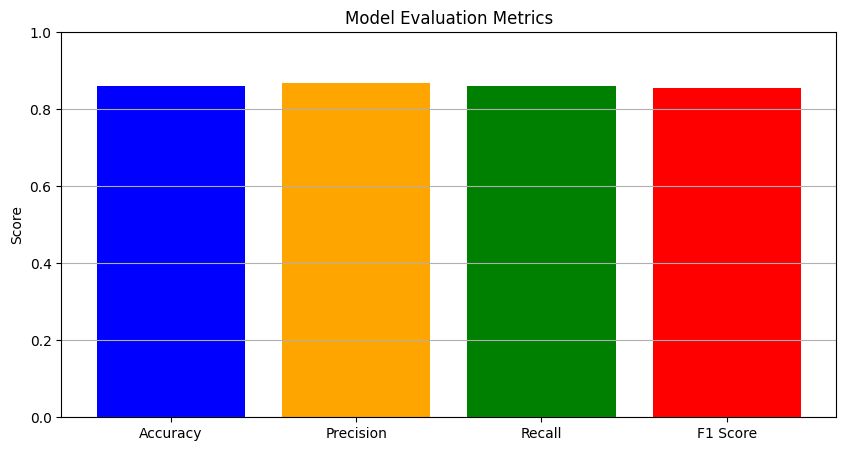

Utterance: 'how do i locate my card?' -> Predicted Intent: 'lost_or_stolen_card'
Utterance: 'check balance in my account' -> Predicted Intent: 'balance_not_updated_after_cheque_or_cash_deposit'
Utterance: 'i need a bank statement.' -> Predicted Intent: 'transfer_into_account'
Utterance: 'i want to deposit some money' -> Predicted Intent: 'top_up_by_cash_or_cheque'


In [42]:
import os
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt






def predict_utterance(utterance):
    inputs = tokenizer(utterance, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():  # No need to track gradients during inference
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    return predicted_class


test_predictions = []
for text in test_data['text']:
    pred = predict_utterance(text)
    test_predictions.append(pred)

# evaluation metrics
accuracy = accuracy_score(test_data['label'], test_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(test_data['label'], test_predictions, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plots
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(10, 5))
plt.bar(metrics, values, color=['blue', 'orange', 'green', 'red'])
plt.ylabel('Score')
plt.title('Model Evaluation Metrics')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


# demonstrations
example_utterances = [
    "how do i locate my card?",
    "check balance in my account",
    "i need a bank statement.",
    "i want to deposit some money",
]

predictions = {utterance: label_encoder.inverse_transform([predict_utterance(utterance)])[0] for utterance in example_utterances}
for utterance, intent in predictions.items():
    print(f"Utterance: '{utterance}' -> Predicted Intent: '{intent}'")


---
**Roberta-base**


In [ ]:
import pandas as pd
import os
dataset="dataset/banking_data"


train=pd.read_csv(os.path.join(dataset,"train.csv"))
test=pd.read_csv(os.path.join(dataset,"test.csv"))
print(test[:10])


                                                text      category
0                           How do I locate my card?  card_arrival
1  I still have not received my new card, I order...  card_arrival
2  I ordered a card but it has not arrived. Help ...  card_arrival
3   Is there a way to know when my card will arrive?  card_arrival
4                       My card has not arrived yet.  card_arrival
5                           When will I get my card?  card_arrival
6  Do you know if there is a tracking number for ...  card_arrival
7                        i have not received my card  card_arrival
8                         still waiting on that card  card_arrival
9  Is it normal to have to wait over a week for m...  card_arrival


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10003 entries, 0 to 10002
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      10003 non-null  object
 1   category  10003 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3080 entries, 0 to 3079
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      3080 non-null   object
 1   category  3080 non-null   object
dtypes: object(2)
memory usage: 48.2+ KB


In [ ]:
category_counts = train['category'].value_counts()
print(category_counts)

cat=pd.read_json(os.path.join(dataset,"categories.json"))
cat.info()
cat['index'] = cat.index
cat.head()

category
card_payment_fee_charged                            187
direct_debit_payment_not_recognised                 182
balance_not_updated_after_cheque_or_cash_deposit    181
wrong_amount_of_cash_received                       180
cash_withdrawal_charge                              177
                                                   ... 
lost_or_stolen_card                                  82
card_swallowed                                       61
card_acceptance                                      59
virtual_card_not_working                             41
contactless_not_working                              35
Name: count, Length: 77, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       77 non-null     object
dtypes: object(1)
memory usage: 744.0+ bytes


,0,index
0,card_arrival,0
1,card_linking,1
2,exchange_rate,2
3,card_payment_wrong_exchange_rate,3
4,extra_charge_on_statement,4




---

**End of task**


---





---



---
IRL tagging -- unsuccessful



In [ ]:
import pandas as pd
import os
dataset="dataset/irl"
schema=pd.read_json(os.path.join(dataset,"train/schema.json"))
schema.info()
schema.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   service_name  26 non-null     object
 1   description   26 non-null     object
 2   slots         26 non-null     object
 3   intents       26 non-null     object
dtypes: object(4)
memory usage: 960.0+ bytes


,service_name,description,slots,intents
0,Banks_1,Manage bank accounts and transfer money,"[{'name': 'account_type', 'description': 'The ...","[{'name': 'CheckBalance', 'description': 'Chec..."
1,Buses_1,Book bus journeys from the biggest bus network...,"[{'name': 'from_location', 'description': 'Cit...","[{'name': 'FindBus', 'description': 'Find a bu..."
2,Buses_2,Find a bus to take you to the city you want,"[{'name': 'origin', 'description': 'Origin cit...","[{'name': 'FindBus', 'description': 'Find a bu..."
3,Calendar_1,Calendar service to manage personal events and...,"[{'name': 'event_date', 'description': 'Date o...","[{'name': 'GetEvents', 'description': 'Get lis..."
4,Events_1,The comprehensive portal to find and reserve s...,"[{'name': 'category', 'description': 'Type of ...","[{'name': 'FindEvents', 'description': 'Find e..."


In [ ]:
df=pd.read_json(os.path.join(dataset,"train/dialogues_001.json"))
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   dialogue_id  128 non-null    int64 
 1   services     128 non-null    object
 2   turns        128 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.1+ KB


,dialogue_id,services,turns
0,100000,[Restaurants_1],[{'frames': [{'actions': [{'act': 'INFORM_INTE...
1,100001,[Restaurants_1],[{'frames': [{'actions': [{'act': 'INFORM_INTE...
2,100002,[Restaurants_1],[{'frames': [{'actions': [{'act': 'INFORM_INTE...
3,100003,[Restaurants_1],[{'frames': [{'actions': [{'act': 'INFORM_INTE...
4,100004,[Restaurants_1],[{'frames': [{'actions': [{'act': 'INFORM_INTE...


In [ ]:
category_counts = df['services'].value_counts()
print(category_counts)


services
[Restaurants_1]    128
Name: count, dtype: int64


In [ ]:

bank_schema = schema[schema['service_name'] == 'Banks_1']

bank_intents = bank_schema['intents'].tolist()
print(bank_intents)

[[{'name': 'CheckBalance', 'description': "Check the amount of money in a user's bank account", 'is_transactional': False, 'required_slots': ['account_type'], 'optional_slots': {}, 'result_slots': ['account_type', 'balance']}, {'name': 'TransferMoney', 'description': "Transfer money from one bank account to another user's account", 'is_transactional': True, 'required_slots': ['account_type', 'amount', 'recipient_account_name'], 'optional_slots': {'recipient_account_type': 'checking'}, 'result_slots': ['account_type', 'recipient_account_type', 'amount', 'recipient_account_name']}]]


In [ ]:
import pandas as pd
import os
import json

df=pd.read_json(os.path.join(dataset,"categories.json"))

print("DataFrame structure:")
print(df.head())

# Step 2: Extract categories from column '0' (assuming column '0' contains the category names)
categories = df[0].tolist()  # Extract the category names as a list of strings

# Step 3: Generate BIO variants for each category
BIO_labels = ['O']  # Always include 'O' for the outside tag
for category in categories:
    BIO_labels.append(f'B-{category}')  # Beginning of the category
    BIO_labels.append(f'I-{category}')  # Inside of the category

# Display the generated BIO labels
print("Generated BIO labels:", BIO_labels)

# Step 4: Create label to ID and ID to label mappings
label2id = {label: idx for idx, label in enumerate(BIO_labels)}
id2label = {idx: label for label, idx in label2id.items()}

# Display the mappings
print("Label to ID mapping:", label2id)
print("ID to Label mapping:", id2label)


DataFrame structure:
                                  0
0                      card_arrival
1                      card_linking
2                     exchange_rate
3  card_payment_wrong_exchange_rate
4         extra_charge_on_statement
Generated BIO labels: ['O', 'B-card_arrival', 'I-card_arrival', 'B-card_linking', 'I-card_linking', 'B-exchange_rate', 'I-exchange_rate', 'B-card_payment_wrong_exchange_rate', 'I-card_payment_wrong_exchange_rate', 'B-extra_charge_on_statement', 'I-extra_charge_on_statement', 'B-pending_cash_withdrawal', 'I-pending_cash_withdrawal', 'B-fiat_currency_support', 'I-fiat_currency_support', 'B-card_delivery_estimate', 'I-card_delivery_estimate', 'B-automatic_top_up', 'I-automatic_top_up', 'B-card_not_working', 'I-card_not_working', 'B-exchange_via_app', 'I-exchange_via_app', 'B-lost_or_stolen_card', 'I-lost_or_stolen_card', 'B-age_limit', 'I-age_limit', 'B-pin_blocked', 'I-pin_blocked', 'B-contactless_not_working', 'I-contactless_not_working', 'B-top_up_by_ba